# TMAA – Projeto #2
### Avaliação e Melhoria de Políticas no Gridworld 4×4

### Grupo 1/2 
- **Pedro Fonte Santa**, ppfsa1@iscte-iul.pt nº 105306  
- **Tiago Ferreira**, tmfaa@iscte-iul.pt, nº 37952  
- **Nuno Martins**, ngasm@iscte-iul.pt, nº 98863  

---

📅 **Data de entrega:** 12 de dezembro de 2025

📊 **Objetivo:** O objetivo deste notebook é implementar e analisar a avaliação de uma política pré-melhoria $\tilde{\pi}$ e a sua melhoria $\tilde{\pi}'$ através do método de policy improvement num ambiente Gridworld 4×4, comparando as funções de valor obtidas antes e depois da melhoria.

---

In [34]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Configurações globais para os gráficos
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['font.size'] = 10

# Opções de visualização do NumPy
np.set_printoptions(precision=3, suppress=True)

## Alinea a)

### Definição do ambiente

Nesta fase define o “mundo” em que o agente vive: o tamanho da grelha (4×4), quais são os estados terminais, a penalização de cada passo (−1) e os parâmetros (gamma, theta e NITER_MAX) que vamos usar mais à frente na avaliação da política.

In [35]:
# Dimensões do Gridworld
grid_size = 4
num_states = grid_size * grid_size

# Ações disponíveis (na mesma ordem que vamos usar mais à frente)
ACTIONS = ['up', 'down', 'left', 'right']
num_actions = len(ACTIONS)

# Estados terminais (coordenadas na grelha: (linha, coluna))
terminal_states = [(0, 0), (3, 3)]

# Recompensa de cada passo (penalização por movimento)
STEP_REWARD = -1.0

# Parâmetros da programação dinâmica
gamma = 1.0       # fator de desconto
theta = 0.01      # limiar de convergência para a avaliação de política
NITER_MAX = 1000  # número máximo de iterações na avaliação

### Funções auxiliares do Gridworld

- Função para converter uma posição (linha, coluna) num índice de estado (0 a 15).
- Outra para fazer o inverso: passar de índice de estado para (linha, coluna).
- E, mais importante, uma função get_next_state_and_reward que implementa a dinâmica do ambiente.

In [36]:
def state_to_index(row, col):
    """
    Converte coordenadas (linha, coluna) num índice de estado (0 a 15).
    """
    return row * grid_size + col


def index_to_state(index):
    """
    Converte um índice de estado (0 a 15) em coordenadas (linha, coluna).
    """
    row = index // grid_size
    col = index % grid_size
    return row, col


def get_next_state_and_reward(state_idx, action):
    """
    Dado um estado (índice) e uma ação, devolve:
    - o índice do próximo estado
    - a recompensa recebida
    
    Se o estado for terminal, o agente permanece no mesmo estado
    e a recompensa é 0.
    """
    row, col = index_to_state(state_idx)

    # Se for estado terminal, não há transição
    if (row, col) in terminal_states:
        return state_idx, 0.0

    # Movimento proposto pela ação
    if action == 'up':
        new_row, new_col = row - 1, col
    elif action == 'down':
        new_row, new_col = row + 1, col
    elif action == 'left':
        new_row, new_col = row, col - 1
    elif action == 'right':
        new_row, new_col = row, col + 1
    else:
        raise ValueError("Ação inválida")

    # Verificar limites da grelha
    if new_row < 0 or new_row >= grid_size or new_col < 0 or new_col >= grid_size:
        # Bate na parede: fica no mesmo estado
        new_row, new_col = row, col

    next_state_idx = state_to_index(new_row, new_col)

    return next_state_idx, STEP_REWARD

### Definição da política inicial $\tilde{\pi}$

Aqui definimos a política inicial não equiprovável pedida no projeto.

Ao contrário da política usada no Lab3 original (π) (onde cada ação tinha probabilidade 1/4), agora usamos uma política fixa e igual em todos os estados não terminais, com as seguintes probabilidades:
- left → 0.4
- right → 0.1
- up → 0.3
- down → 0.2

A política vai ser representada como uma matriz policy[s, a], onde:
s é o índice do estado (0 a 15),
a é o índice da ação (0 a 3, na ordem definida em ACTIONS).

In [ ]:
# policy[s, a] = probabilidade de executar a ação a no estado s
policy = np.zeros((num_states, num_actions))

# Probabilidades definidas no enunciado
action_probs = {
    'left': 0.4,
    'right': 0.1,
    'up': 0.3,
    'down': 0.2
}

# Preencher a política para todos os estados
for s in range(num_states):
    for a, action in enumerate(ACTIONS):
        policy[s, a] = action_probs[action]

### Avaliação de política

Nesta fase calculamos a **função de valor** $v_{\tilde{\pi}}(s)$ associada à política $\tilde{\pi}$ definida anteriormente.

A ideia é simples:

- Inicializamos a função de valor com zeros em todos os estados.
- Iterativamente atualizamos o valor de cada estado usando a equação de Bellman para avaliação de política:

$$
v_{\tilde{\pi}}(s)
= \sum_a \pi(a \mid s)
\sum_{s'} p(s' \mid s, a)
\left[ r + \gamma v_{\pi}(s') \right]
$$

Como o ambiente do Gridworld é **determinístico**, para cada par $(s,a)$ existe apenas um único próximo estado possível.

O processo repete-se até que a variação máxima dos valores seja inferior a $\theta$  
ou até atingirmos $NITER\_MAX$.

In [38]:
def policy_evaluation(policy, gamma=1.0, theta=0.01, max_iterations=1000):
    """
    Avaliação síncrona de uma política.
    
    Devolve:
    - V: vetor com o valor de cada estado
    - n_iter: número de iterações até convergir
    """
    V = np.zeros(num_states)

    for it in range(max_iterations):
        delta = 0.0
        V_new = np.zeros_like(V)

        for s in range(num_states):
            row, col = index_to_state(s)

            # Estados terminais têm valor 0
            if (row, col) in terminal_states:
                continue

            value_s = 0.0
            for a, action in enumerate(ACTIONS):
                prob = policy[s, a]
                next_s, reward = get_next_state_and_reward(s, action)
                value_s += prob * (reward + gamma * V[next_s])

            V_new[s] = value_s
            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new

        if delta < theta:
            return V, it + 1

    return V, max_iterations

### Executar a avaliação da política $\tilde{\pi}$

In [39]:
V_pi, n_iter = policy_evaluation(policy, gamma=gamma,
                                   theta=theta, max_iterations=NITER_MAX)

print(f"N.º de iterações até convergir: {n_iter}")
print("\nVetor de valores (índices de 0 a 15):\n")
print(V_pi)

N.º de iterações até convergir: 63

Vetor de valores (índices de 0 a 15):

[  0.     -5.685  -9.998 -12.825  -7.839  -9.909 -12.229 -13.503 -13.58
 -14.243 -14.605 -12.097 -16.894 -16.924 -15.179   0.   ]


### Mostrar os valores na forma de grelha 4×4

In [57]:
# Reorganizar V na forma de grelha 4x4
V_grid = V_pi.reshape((grid_size, grid_size))

print("\nFunção de valor v{π} organizada em grelha (linha x coluna):\n")
print(np.round(V_grid, 3))  # arredondar para 3 casas decimais


Função de valor v{π} organizada em grelha (linha x coluna):

[[  0.     -5.685  -9.998 -12.825]
 [ -7.839  -9.909 -12.229 -13.503]
 [-13.58  -14.243 -14.605 -12.097]
 [-16.894 -16.924 -15.179   0.   ]]


### Mostrar os valores na forma de Heatmap

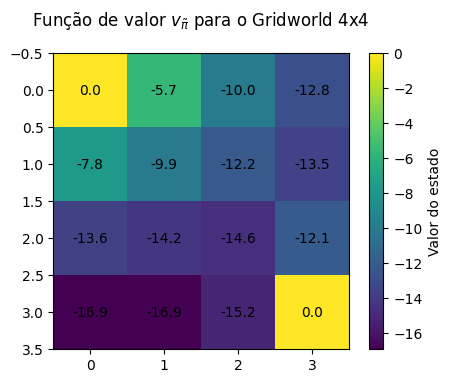

In [60]:
plt.figure(figsize=(5, 4))

im = plt.imshow(V_grid, origin='upper')
cbar = plt.colorbar(im)
cbar.set_label('Valor do estado')

plt.title('Função de valor $v_{\\tilde{\\pi}}$ para o Gridworld 4x4', pad=20)

for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f"{V_grid[i, j]:.1f}",
                 ha='center', va='center')

plt.subplots_adjust(top=0.85)
plt.show()

## Alinea b)

In [42]:
# Lista de índices dos estados terminais (0 a 15)
terminal_states_indices = [state_to_index(r, c) for (r, c) in terminal_states]

def print_value_info(V, title="Função de valor"):
    """
    Mostra:
    - a grelha 4x4 com os valores dos estados
    - os valores distintos encontrados (ordenados)
    """
    V_grid = V.reshape((grid_size, grid_size))
    
    print(f"\n{title} (forma vetorial):\n")
    print(np.round(V, 3))
    
    print(f"\n{title} em grelha 4x4:\n")
    print(np.round(V_grid, 3))
    
    unique_vals = np.unique(np.round(V, 3))
    print("\nValores distintos (arredondados a 3 casas decimais):")
    print(unique_vals)

### Função de melhoria da política (para obter $\tilde{\pi}'$)

Vamos criar uma função `policy_improvement` que, dada:

- uma função de valor $V$  
- e a dinâmica do ambiente (`get_next_state_and_reward`),

constrói uma nova política melhorada $\tilde{\pi}'$, escolhendo, em cada estado não terminal, a(s) ação(ões) com maior valor esperado:

$$
q(s,a) = r + \gamma \, V(s')
$$

In [ ]:
def policy_improvement(V, gamma=1.0):

    new_policy = np.zeros((num_states, num_actions))
    
    for s in range(num_states):
        # Ignorar estados terminais: mantêm política 0
        if s in terminal_states_indices:
            continue
        
        q_values = np.zeros(num_actions)
        
        # Calcular q(s,a) = r + gamma * V(s')
        for a, action in enumerate(ACTIONS):
            next_s, reward = get_next_state_and_reward(s, action)
            q_values[a] = reward + gamma * V[next_s]
        
        # Ações ótimas (pode haver mais do que uma com o mesmo valor máximo)
        max_q = np.max(q_values)
        best_actions = np.where(q_values == max_q)[0]
        
        # Distribuir probabilidade uniformemente pelas ações ótimas
        for a in best_actions:
            new_policy[s, a] = 1.0 / len(best_actions)
    
    return new_policy

### Obter e Avaliar a nova política melhorada $\tilde{\pi}'$

Neste bloco vamos:

- Usar a função `policy_improvement` para obter a política melhorada $\tilde{\pi}'$ a partir de $V_{\tilde{\pi}}$.
- Avaliar essa nova política com a função `policy_evaluation`.
- Mostrar um pequeno resumo numérico dos valores obtidos para comparar a política original com a política melhorada.

In [64]:
# Obter a política melhorada \~{\pi}'
policy_improved = policy_improvement(V_pi, gamma=gamma)

# Avaliar a nova política melhorada \~{\pi}'
V_pi_improved, n_iter_improved = policy_evaluation(policy_improved,
                                                   gamma=gamma,
                                                   theta=theta,
                                                   max_iterations=NITER_MAX)

print(f"N.º de iterações até convergir (política melhorada): {n_iter_improved}")

# Informações sobre os valores da política original e da melhorada
print_value_info(V_pi, title="Função de valor v{π} (política pré-melhoria)")
print_value_info(V_pi_improved, title="Função de valor v{π'} (política melhorada)")

N.º de iterações até convergir (política melhorada): 5

Função de valor v{π} (política pré-melhoria) (forma vetorial):

[  0.     -5.685  -9.998 -12.825  -7.839  -9.909 -12.229 -13.503 -13.58
 -14.243 -14.605 -12.097 -16.894 -16.924 -15.179   0.   ]

Função de valor v{π} (política pré-melhoria) em grelha 4x4:

[[  0.     -5.685  -9.998 -12.825]
 [ -7.839  -9.909 -12.229 -13.503]
 [-13.58  -14.243 -14.605 -12.097]
 [-16.894 -16.924 -15.179   0.   ]]

Valores distintos (arredondados a 3 casas decimais):
[-16.924 -16.894 -15.179 -14.605 -14.243 -13.58  -13.503 -12.825 -12.229
 -12.097  -9.998  -9.909  -7.839  -5.685   0.   ]

Função de valor v{π'} (política melhorada) (forma vetorial):

[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -4. -1.  0.]

Função de valor v{π'} (política melhorada) em grelha 4x4:

[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -4. -1.  0.]]

Valores distintos (arredondados a 3 casas decimais):
[-4. -3. -2. -1.  0.]


### Heatmaps para comparar $v_{\tilde{\pi}}$ e $v_{\tilde{\pi}'}$

Dois mapas de calor lado a lado:

- Um para a função de valor da política original $\tilde{\pi}$.
- Outro para a função de valor da política melhorada $\tilde{\pi}'$.

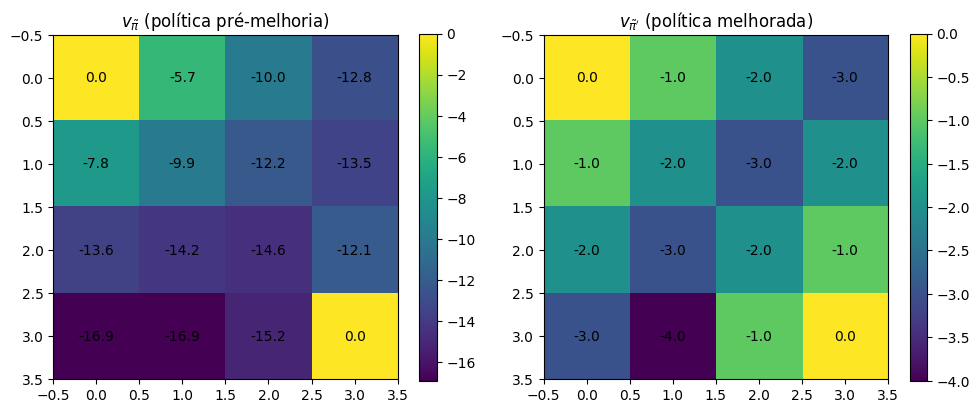

In [65]:
V1 = V_pi.reshape((grid_size, grid_size))
V2 = V_pi_improved.reshape((grid_size, grid_size))

plt.figure(figsize=(10, 4))

# Heatmap da política original
plt.subplot(1, 2, 1)
im1 = plt.imshow(V1, origin='upper')
plt.title(r"$v_{\tilde{\pi}}$ (política pré-melhoria)")
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f"{V1[i,j]:.1f}", ha='center', va='center')
plt.colorbar(im1)

# Heatmap da política melhorada
plt.subplot(1, 2, 2)
im2 = plt.imshow(V2, origin='upper')
plt.title(r"$v_{\tilde{\pi}'}$ (política melhorada)")
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f"{V2[i,j]:.1f}", ha='center', va='center')
plt.colorbar(im2)

plt.tight_layout()
plt.show()

### Obter a política ótima $v*$

In [46]:
def policy_iteration(policy, gamma=1.0, theta=0.01, max_outer_iterations=100):
    """
    Executa policy iteration completa até convergência.
    """
    for i in range(max_outer_iterations):
        V, _ = policy_evaluation(policy, gamma=gamma, theta=theta)
        new_policy = policy_improvement(V, gamma=gamma)

        # política estabilizou
        if np.array_equal(new_policy, policy):
            print(f"Política ótima encontrada após {i+1} iterações.")
            return policy, V, i + 1

        policy = new_policy

    print("Número máximo de iterações atingido.")
    return policy, V, max_outer_iterations

policy_opt, V_opt, n_policy_iter = policy_iteration(
    policy,
    gamma=gamma,
    theta=theta
)

Política ótima encontrada após 4 iterações.


### Heatmap para $v*$ (política ótima)

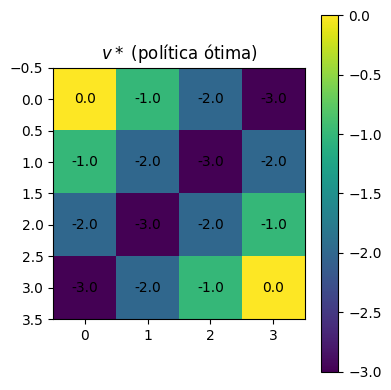

In [ ]:
V_opt_grid = V_opt.reshape((grid_size, grid_size))

plt.figure(figsize=(4, 4))

im = plt.imshow(V_opt_grid, origin='upper', cmap='viridis')
plt.title("$v*$ (política ótima)")

for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f"{V_opt_grid[i, j]:.1f}", 
                 ha='center', va='center')

plt.colorbar(im)
plt.tight_layout()
plt.show()

### Conclusão



A partir dos resultados obtidos, vemos primeiro que a política inicial $\tilde{\pi}$ (com probabilidades diferentes para cada ação) conduz a valores de estado bastante negativos, o que indica que o agente demora, em média, muito tempo a atingir um estado terminal quando segue essa política. Isto reflete um comportamento pouco eficiente, com trajetórias longas e elevado custo acumulado.

Após a aplicação de *policy improvement* à política $\tilde{\pi}$, obtemos uma nova política $\tilde{\pi}'$ cuja função de valor $v_{\tilde{\pi}'}(s)$ apresenta valores significativamente menos negativos. Ainda assim, surge um estado com valor $-4$, o que mostra que, apesar de a política melhorada ser claramente superior à original, ela não é ainda ótima. Apenas ao aplicar *policy iteration* completa é que se obtém a política ótima, cuja função de valor $v^*(s)$ coincide com a apresentada na Figura 4.1 de Sutton & Barto, assumindo apenas os valores $0$, $-1$, $-2$ e $-3$.